Import needed set of packages

In [1]:
import datetime
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from tools import rednt_tools as tools  # custom helper tools library

Read the data from the CSV files with timestamp as index column

In [2]:
v_df = pd.read_csv(tools.VIBRATION_FILENAME, sep=tools.SEP, header=None,
                   names=tools.V_HEADER_NAMES, index_col=[0], parse_dates=[0],
                   date_parser=tools.date_parser)

t_df = pd.read_csv(tools.TEMPERATURE_FILENAME, sep=tools.SEP, header=None,
                   names=tools.T_HEADER_NAMES, index_col=[0], parse_dates=[0],
                   date_parser=tools.date_parser)

Make sure that both of the data are sorted

In [3]:
v_df = v_df.sort_values(by='timestamp')
t_df = t_df.sort_values(by='timestamp')

Determine some timestamp characterstics - start time, end time and time horizon of signals

In [4]:
timestamp_chars = {
    'vibration': {
        'start': v_df.index.to_series()[0],
        'end': v_df.index.to_series()[-1],
        'horizon': v_df.index.to_series()[-1] - v_df.index.to_series()[0]
    },
    'temperature': {
        'start': t_df.index.to_series()[0],
        'end': t_df.index.to_series()[-1],
        'horizon': t_df.index.to_series()[-1] - v_df.index.to_series()[0]
    }
}

print("Timestamp characteristics:")
print(timestamp_chars)

Timestamp characteristics:
{'vibration': {'start': Timestamp('2021-10-01 00:46:13'), 'end': Timestamp('2022-01-17 08:46:11'), 'horizon': Timedelta('108 days 07:59:58')}, 'temperature': {'start': Timestamp('2021-10-01 00:46:13'), 'end': Timestamp('2022-01-17 08:45:20'), 'horizon': Timedelta('108 days 07:59:07')}}


Calculate signal timestamp differences between samples and some statistics about it

In [5]:
v_timestamp_diff = v_df.index.to_series().diff()
t_timestamp_diff = t_df.index.to_series().diff()

timestamp_diff = pd.concat([v_timestamp_diff, t_timestamp_diff])
timedelta_value_counts = timestamp_diff.value_counts()

print('Timestamp differences:')
print(timedelta_value_counts)

timedelta_statistics = {
    'mean': timestamp_diff.mean(),
    'median': timestamp_diff.median(),
    'mode': timestamp_diff.mode(),
    'max': timestamp_diff.max(),
    'min': timestamp_diff.min()
}

print('Timestamp differences statistics:')
print(timedelta_statistics)

Timestamp differences:
0 days 00:00:02    569472
0 days 00:00:03    115271
0 days 00:01:00    106229
0 days 00:00:04    103433
0 days 00:00:01     71426
                    ...  
0 days 01:44:56         1
0 days 00:39:14         1
0 days 00:12:30         1
0 days 02:02:36         1
0 days 00:14:02         1
Name: timestamp, Length: 591, dtype: int64
Timestamp differences statistics:
{'mean': Timedelta('0 days 00:00:14.677659'), 'median': Timedelta('0 days 00:00:02'), 'mode': 0   0 days 00:00:02
dtype: timedelta64[ns], 'max': Timedelta('10 days 15:18:40'), 'min': Timedelta('0 days 00:00:00')}


Deduce sampling time with timedelta as the median from the diffs

In [6]:
timedelta = timedelta_statistics['median']

print("Median Timedelta that we choose as sampling time: {}".format(timedelta))
sampling_time = timedelta

Median Timedelta that we choose as sampling time: 0 days 00:00:02


Upsample the missing data with the NaNs

In [7]:
v_df = v_df.resample(sampling_time).mean().interpolate(method='zero')
t_df = t_df.resample(sampling_time).mean().interpolate(method='zero')

Merge dataframes based on the closest timestamp and limit to smallest length

In [8]:
merge_tolerance = sampling_time
if len(v_df) > len(t_df):
    df = pd.merge_asof(t_df, v_df, on='timestamp', tolerance=merge_tolerance)
else:
    df = pd.merge_asof(v_df, t_df, on='timestamp', tolerance=merge_tolerance)

Drop rows containing NaN values

In [9]:
df = df.dropna()

Print the dataframe

In [10]:
print(df)

                  timestamp  temperature  vibration
0       2021-10-01 00:46:12       0.0000       0.45
1       2021-10-01 00:46:14       0.0000       0.45
2       2021-10-01 00:46:16       0.0000       0.45
3       2021-10-01 00:46:18       0.0000       0.45
4       2021-10-01 00:46:20       0.0000       0.45
...                     ...          ...        ...
4679970 2022-01-17 08:45:12      84.7500       1.30
4679971 2022-01-17 08:45:14      84.7500       1.30
4679972 2022-01-17 08:45:16      84.6562       1.57
4679973 2022-01-17 08:45:18      85.3125       1.22
4679974 2022-01-17 08:45:20      84.8438       1.22

[4679975 rows x 3 columns]


Plot the timeseries data

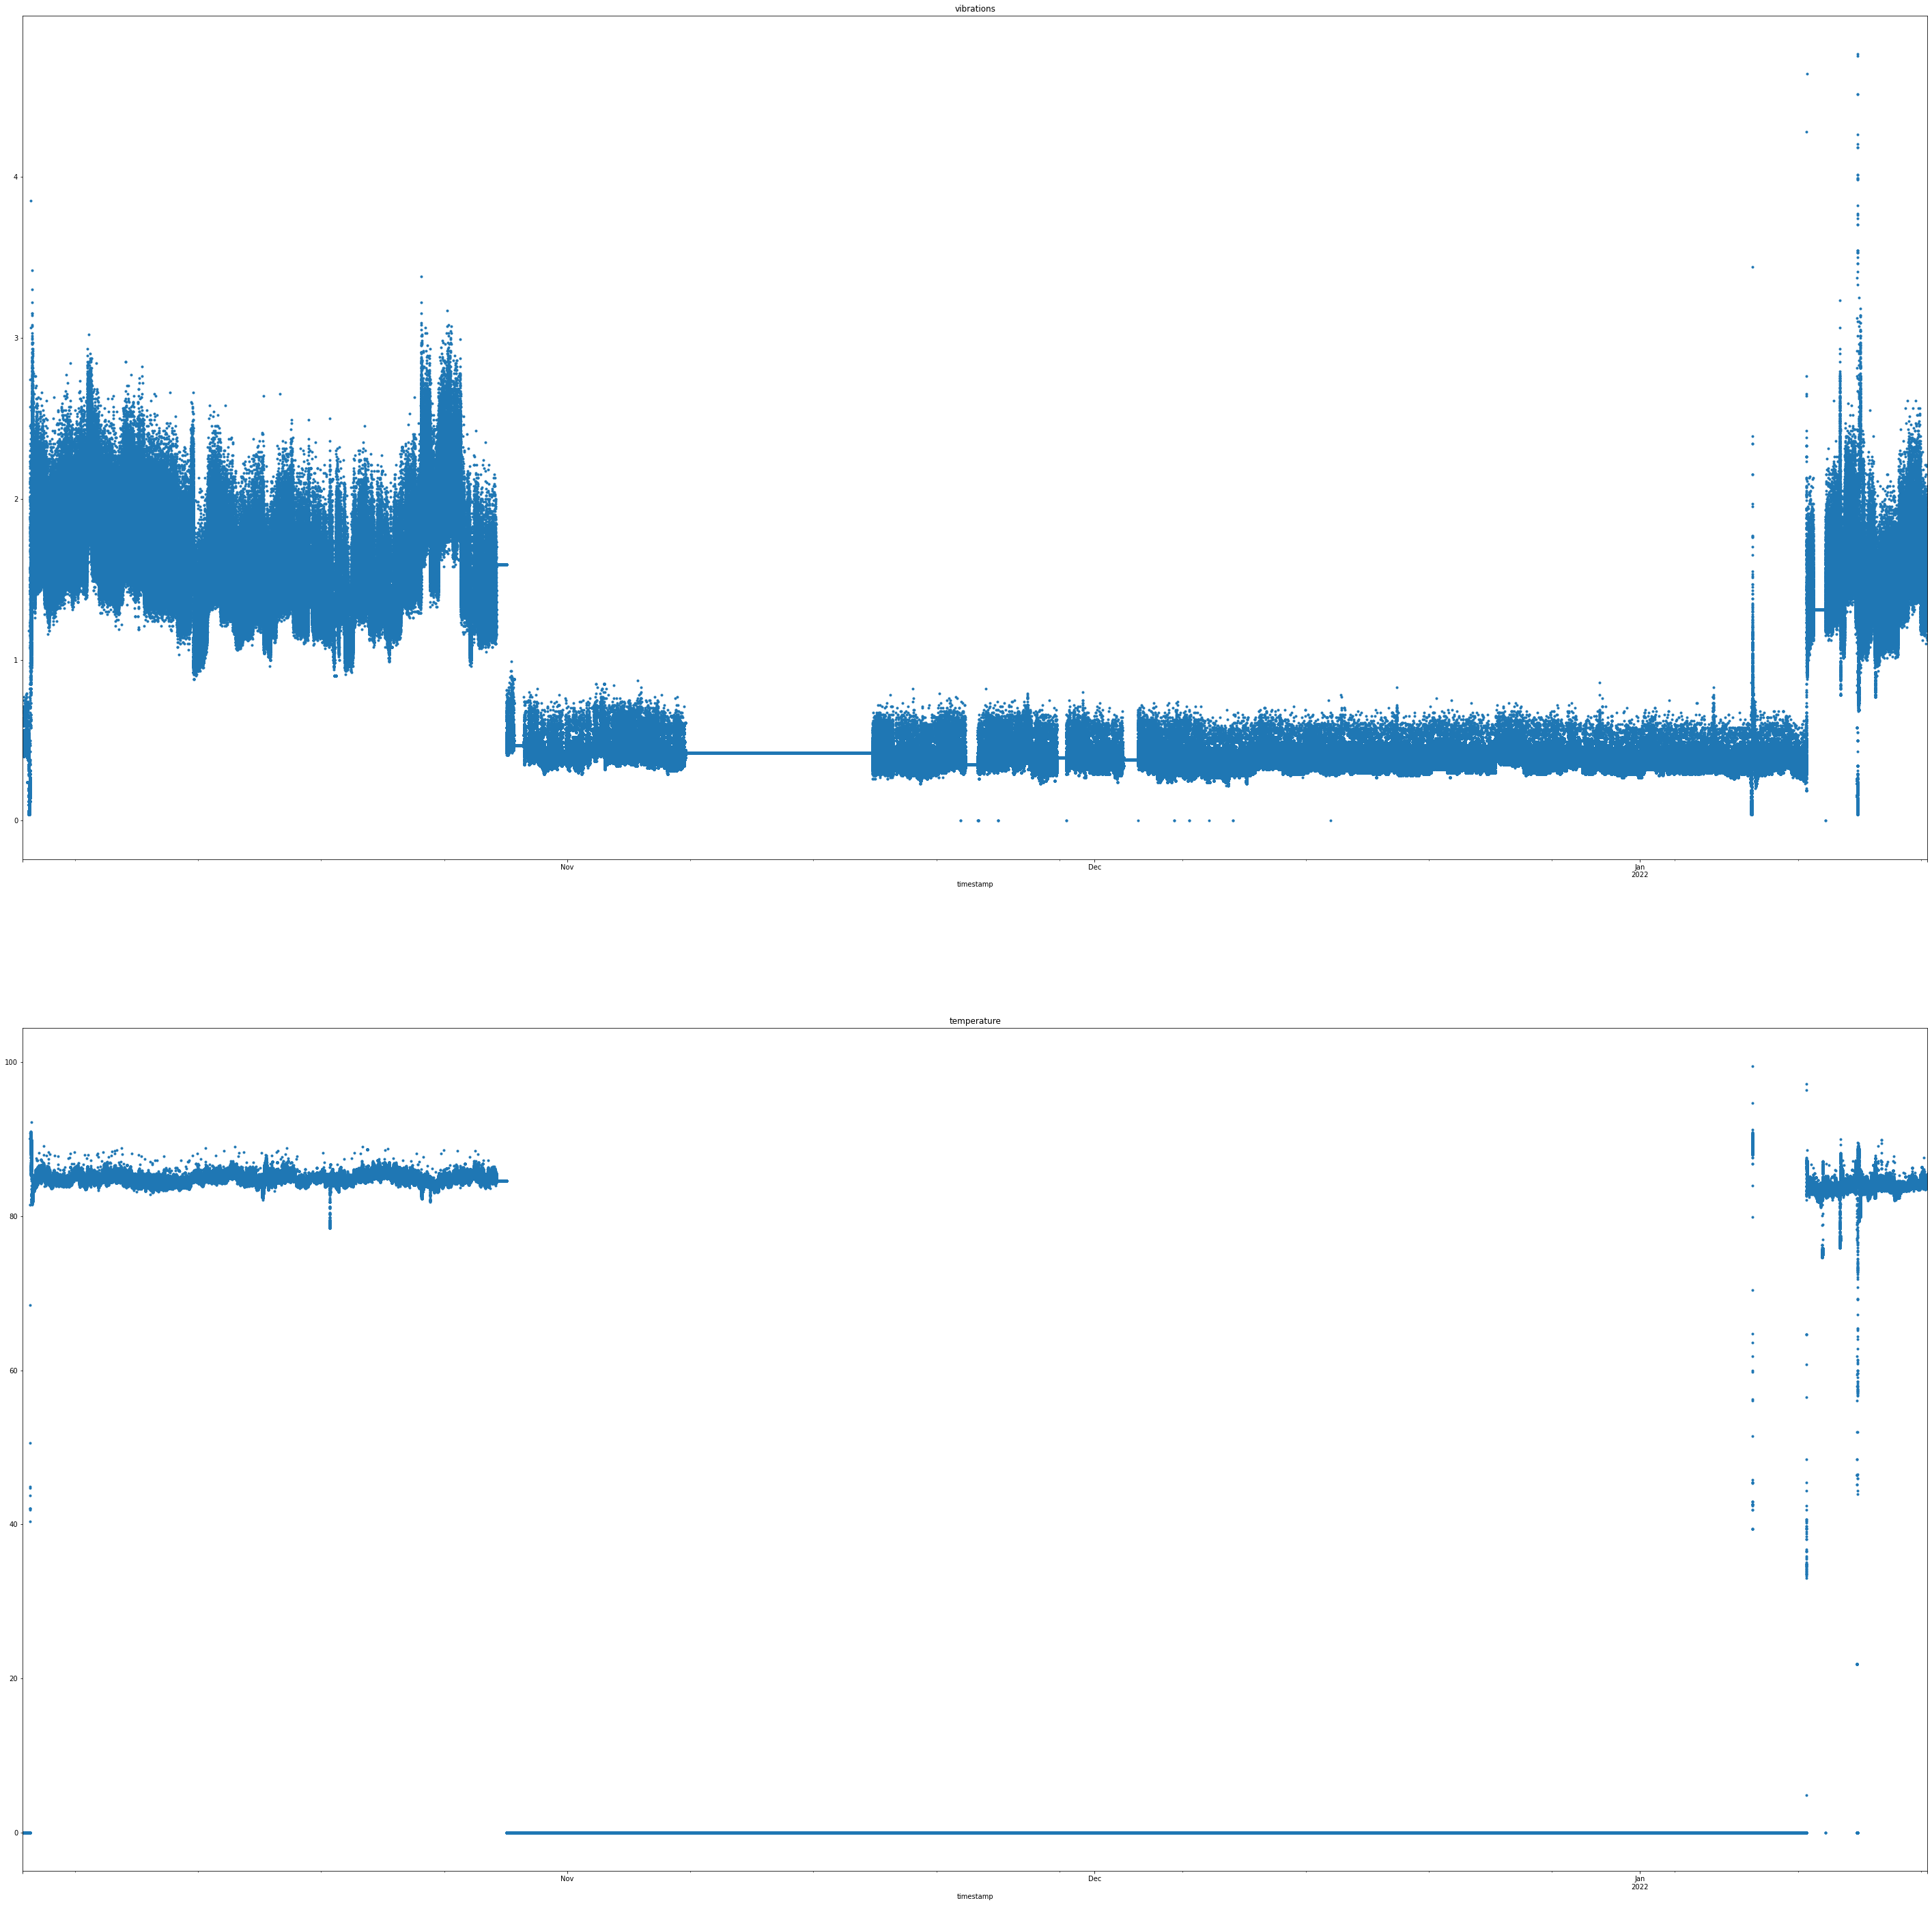

In [11]:
tools.plot_timeseries_data(df)

Create helper series

In [12]:
#df = df.set_index('timestamp').index

#print(df.set_index('timestamp').index)

AttributeError: 'DatetimeIndex' object has no attribute 'set_index'

Remove unwanted outliers from signal to smooth the data using Hampel filter

In [ ]:
#df = df.apply(tools.remove_outliers)

Plot the timeseries data after filtering out the outliers

In [ ]:
tools.plot_timeseries_data(df)